In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
import pymc3 as pm
import arviz as az
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
#import covid19_inference as cov19
from header_plotting import *
from utils import getNoSoccer, getPrimary



In [2]:
%load_ext autoreload
%autoreload 2

In [111]:
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig_path = "../figures/SI"

xlim_ts = [ # Plotting x lims
    datetime.datetime(2021,5,30),
    datetime.datetime(2021,7,23)
] 

def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
countries = ['England', 'Czechia']

traces,traces_without_soccer,traces_primary_soccer, models, dls = [], [], [], [],[]
for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)
    
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")

    traces_without_soccer.append(trace_without_soccer)
    traces_primary_soccer.append(trace_primary_soccer)

  0%|          | 0/2 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia


## England without final but only groupstage


In [4]:
df = pd.read_csv("../../data/em_game_data.csv",header=2)
#df = df[~df["id"].str.contains("a")] # Filter extra games we added for validation these are suffixed with a
df[" date"]= pd.to_datetime(df[" date"])
df

,id,date,phase,team1,team2,goals1,goals2,location
0,000,2021-06-11,GS,TR,IT,0,3,Rome
1,001,2021-06-12,GS,GB-WLS,CH,1,1,Baku
2,002,2021-06-12,GS,DK,FI,0,1,Copenhagen
3,003,2021-06-12,GS,BE,RU,3,0,Saint Petersburg
4,004,2021-06-13,GS,GB-ENG,HR,1,0,London
5,005,2021-06-13,GS,AT,MK,3,1,Bucharest
6,006,2021-06-13,GS,NL,UA,3,2,Amsterdam
7,007,2021-06-14,GS,GB-SCT,CZ,0,2,Glasgow
8,008,2021-06-14,GS,PL,SK,1,2,Saint Petersburg
9,009,2021-06-14,GS,ES,SE,0,0,Seville


In [269]:
import arviz as az
import pymc3 as pm
import copy


# Edit england trace to non groupphase games to 0 percent
def get_samples_no_groupstage(orig_trace,orig_model,orig_dl,var_names=["new_E_t","new_cases","R_t_soccer", "S_t", "new_I_t", "R_t_base","R_t_add_noise_fact", "C_base", "C_soccer","alpha_R"], load_saved=False):
    """ Remove non group phase effects and
        get posterior predictive samples from new trace.
        
        Parameters
        ----------
        orig_trace:
            Original trace
        orig_model:
            Original model
        orig_dl:
            Original dataloader
        var_names:
            Variable names to sample
    """
    
    # Mask for groupstage game
    iso2 = orig_dl.countries_iso2[0]
    df = pd.read_csv("../../data/em_game_data.csv",header=2)
    t = df[df[' team1'].str.contains(iso2) | df[' team2'].str.contains(iso2)]
    mask_no_GS = ~(t[" phase"].str.contains("GS"))
    
    # Edit original trace
    trace_no_GS = copy.deepcopy(orig_trace)
    mean_alpha =  trace_no_GS.posterior["alpha_mean"].values[...,None]
    sigma_alpha = trace_no_GS.posterior["sigma_alpha_g"].values[...,None]
    trace_no_GS.posterior["Delta_alpha_g_sparse"].values[:,:,mask_no_GS] = -mean_alpha/sigma_alpha
    

    
    
    if not load_saved:
        # Sample posterior predictive
        ret_trace = pm.fast_sample_posterior_predictive(
            trace_no_GS,
            model=orig_model,
            var_names=var_names,
            keep_size=True,
        )
        prediction_no_GS = az.from_pymc3_predictions(ret_trace)
        
        for var in ["new_E_t","new_cases","R_t_soccer", "S_t", "new_I_t", "R_t_base","R_t_add_noise_fact", "C_base", "C_soccer","alpha_R"]:
            trace_no_GS.posterior[var] = (trace_no_GS.posterior[var].dims,prediction_no_GS.predictions[var].values[0,...])

        trace_no_GS_no_soccer = getNoSoccer(copy.deepcopy(trace_no_GS),models[0])
        trace_no_GS_primary = getPrimary(trace_no_GS,trace_no_GS_no_soccer,models[0],dls[0])
    
        # Save
        with open(f"/data.nst/smohr/covid19_soccer_data/Czechia_with_England_participation2.pkl", "wb") as f:
            pickle.dump((trace_no_GS, trace_no_GS_no_soccer, trace_no_GS_primary), f)
    else:
        with open(f"/data.nst/smohr/covid19_soccer_data/Czechia_with_England_participation2.pkl", "rb") as f:
            trace_no_GS, trace_no_GS_no_soccer, trace_no_GS_primary = pickle.load(f)

    return trace_no_GS, trace_no_GS_no_soccer, trace_no_GS_primary
    


In [270]:
trace_no_GS, trace_no_GS_no_soccer, trace_no_GS_primary = get_samples_no_groupstage(traces[0],models[0],dls[0], load_saved=True)


## Czechia but with matches of England

In [272]:
from covid19_soccer.models import create_model_gender

def get_samples_czechia_with_England_participation(
    orig_trace, orig_model, orig_dl,
    participation_trace, participation_model, participation_dl,
    var_names=["new_E_t","new_cases","R_t_soccer"],
    load_saved=False
):
    """ Overwrite a trace with base from another one
        get posterior predictive samples from new trace.
        
        Parameters
        ----------
        orig_trace:
            Original trace
        orig_model:
            Original model
        orig_dl:
            Original dataloader
        overwrite_trace:
            Trace which is used to overwrite values in org
        overwrite_model:
        overwrite_dl:
        var_names:
            Variable names to sample
    """
    
    # Create model with new alpha_prior
    new_model = create_model_gender(
        dataloader=orig_dl,
        beta=False,
        force_alpha_prior=participation_dl.alpha_prior[0, :]
    )
    
    # Overwrite Delta_alpha_g_sparse
    new_trace = copy.deepcopy(participation_trace)
    for key in list(participation_trace.posterior.data_vars):
        if "Delta_alpha_g_sparse" in key or "alpha_mean" in key or "sigma_alpha_g" in key:
            continue
        else:
            new_trace.posterior[key] = orig_trace.posterior[key]
    #new_trace.posterior["Delta_alpha_g_sparse"] = (
    #    new_trace.posterior["Delta_alpha_g_sparse"].dims,
    #    np.ones((new_trace.posterior["Delta_alpha_g_sparse"].shape[0],new_trace.posterior["Delta_alpha_g_sparse"].shape[1]))[...,None]*(
    #        new_trace.posterior["Delta_alpha_g_sparse"].mean(axis=(0,1)).values +
    #        new_trace.posterior["alpha_mean"].mean().values
    #    )
    #)
    #new_trace.posterior["alpha_mean"] = (
    #    new_trace.posterior["alpha_mean"].dims,
    #    np.zeros((new_trace.posterior["alpha_mean"].shape[0],new_trace.posterior["alpha_mean"].shape[1]))
    #)
    
    print(new_trace.posterior["alpha_mean"].mean(axis=(0,1)))
    print(new_trace.posterior["Delta_alpha_g_sparse"].mean(axis=(0,1)))
    # As the dimensions of the alpha_g sparse vector might not match we use the participation_model here
    if not load_saved:
        ret_trace = pm.fast_sample_posterior_predictive(
            new_trace,
            model=new_model,
            var_names=var_names,
            keep_size=True,
        )
        prediction_czechia_with_england_participation,trace_czechia_with_england_participation = (az.from_pymc3_predictions(ret_trace, model=new_model), new_trace)
        trace_czechia_with_england_participation.posterior["new_E_t"] = (trace_czechia_with_england_participation.posterior["new_E_t"].dims,prediction_czechia_with_england_participation.predictions["new_E_t"].values[0,...])
        trace_czechia_with_england_participation.posterior["new_cases"] = (trace_czechia_with_england_participation.posterior["new_cases"].dims,prediction_czechia_with_england_participation.predictions["new_cases"].values[0,...])

        trace_czechia_with_england_participation_no_soccer = getNoSoccer(trace_czechia_with_england_participation,new_model)
        trace_czechia_with_england_participation_primary = getPrimary(trace_czechia_with_england_participation,trace_czechia_with_england_participation_no_soccer,new_model,dls[1])
        # Save
        with open(f"/data.nst/smohr/covid19_soccer_data/Czechia_with_England_participation2.pkl", "wb") as f:
            pickle.dump((trace_czechia_with_england_participation,trace_czechia_with_england_participation_no_soccer,trace_czechia_with_england_participation_primary), f)
    else:
        with open(f"/data.nst/smohr/covid19_soccer_data/Czechia_with_England_participation2.pkl", "rb") as f:
            trace_czechia_with_england_participation,trace_czechia_with_england_participation_no_soccer,trace_czechia_with_england_participation_primary = pickle.load(f)
    return trace_czechia_with_england_participation,trace_czechia_with_england_participation_no_soccer,trace_czechia_with_england_participation_primary

In [273]:
trace_czechia_with_england_participation,trace_czechia_with_england_participation_no_soccer,trace_czechia_with_england_participation_primary = get_samples_czechia_with_England_participation(
    traces[1],models[1],dls[1],
    traces[0],models[0],dls[0],
    load_saved=True
)


INFO     [covid19_soccer.models] Country: Czechia, prior_delay = 5
INFO     [covid19_soccer.utils] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_soccer.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_soccer.effect_gender] R_t_soccer with deltas
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_E
INFO     [covid19_soccer.compartmental_models] kernelized spread soccer
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_soccer.delay_by_weekday] Delaying cases by weekday


<xarray.DataArray 'alpha_mean' ()>
array(0.77379087)
<xarray.DataArray 'Delta_alpha_g_sparse' (Delta_alpha_g_sparse_dim_0: 7)>
array([-0.98021879, -0.20032258, -0.57721215,  0.26551141, -0.1911074 ,
        0.04911435,  1.71914087])
Coordinates:
  * Delta_alpha_g_sparse_dim_0  (Delta_alpha_g_sparse_dim_0) int64 0 1 2 3 4 5 6


In [271]:
        with open(f"/data.nst/smohr/covid19_soccer_data/Czechia_with_England_participation2.pkl", "wb") as f:
            pickle.dump((trace_czechia_with_england_participation,trace_czechia_with_england_participation_no_soccer,trace_czechia_with_england_participation_primary), f)

# I have no idea for what this function is for

In [51]:
def get_samples_with_cases_and_R_from_second_trace(
    orig_trace, orig_model, orig_dl,
    overwrite_trace, overwrite_model, overwrite_dl,
    var_names=["new_E_t","new_cases"]
):
    """ Overwrite a trace with base from another one
        get posterior predictive samples from new trace.
        
        Parameters
        ----------
        orig_trace:
            Original trace
        orig_model:
            Original model
        orig_dl:
            Original dataloader
        overwrite_trace:
            Trace which is used to overwrite values in org
        overwrite_model:
        overwrite_dl:
        var_names:
            Variable names to sample
    """
    
    # 1. Overwrite R_base i.e. all lambda cps
    new_trace = copy.deepcopy(orig_trace)
    for key in list(orig_trace.posterior.data_vars):
        if "lambda" in key or "transient" in key or "I_begin" in key:
            new_trace.posterior[key] = overwrite_trace.posterior[key]
        if key == "I_begin_ratio_log_L2_raw":
            new_trace.posterior[key] = (
                overwrite_trace.posterior[key] + 1.0/ overwrite_trace.posterior["sigma_I_begin_ratio_log_L1"].values[...,None] * np.log(
                    np.nansum(overwrite_model.new_cases_obs[:5], axis=0) /
                    np.nansum(orig_model.new_cases_obs[:5], axis=0) 
                )
            )

    # 2. Sample posterior predictive
    ret_trace = pm.fast_sample_posterior_predictive(
        new_trace,
        model=orig_model,
        var_names=var_names,
        keep_size=True,
    )
    return az.from_pymc3_predictions(ret_trace), new_trace

In [264]:
trace_england_no_soccer = getNoSoccer(traces[0],models[0])
trace_england_primary = getPrimary(traces[0],trace_england_no_soccer,models[0],dls[0])
trace_czechia_no_soccer = getNoSoccer(traces[1],models[1])
trace_czechia_primary = getPrimary(traces[1],trace_czechia_no_soccer,models[1],dls[1])

ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/jdehning/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
INFO     [covid19_soccer.utils] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_soccer.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_soccer.delay_by_weekday] Delaying cases by weekday
ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
INFO 

## Plotting

In [187]:
def get_xy(trace,trace_without_soccer,trace_primary_soccer):
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(model.sim_begin, model.sim_end)
    y0 = np.median(trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]), axis = 0)
    y1 = np.median(trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]), axis=0) - y0
    y2 = np.median(trace.posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]), axis=0) - y1 - y0
    
    y = [
        y0[...,0]+y0[...,1],
        y1[...,0]+y1[...,1],
        y2[...,0]+y2[...,1]
    ]
    return x, y

In [129]:
def get_primary_and_subsequent(trace,trace_without_soccer,trace_primary_soccer):
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4])
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y0
    y2 = trace.posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y1 - y0
    
    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    
    y0 = np.sum(y0[..., i_begin:i_end, :], axis=(-2,-1)) #no soccer
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=(-2,-1)) #primary
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=(-2,-1)) #subsequent

    return y1+y2 
    


In [253]:
def plot_var(ax, dat, y_pos, color, ci=0.95, vertical=True):
    """ Plots horizontal lines in typical style for a variable. Only works for ndim=1
    
        Parameters
        ----------
        ax:
            Matplotlib axes
        trace:
            Trace for getting the var
        var: string
            Var name
        y_pos: 
            Position of lineplot
        ci: number
            Ci to use for highlighting
    """


    # Get percentiles
    m,l2,l1,u1,u2 = np.percentile(dat,q=(50,2.5,25,75,97.5))
    
    if vertical:
        lines_func = lambda pos, data_min, data_max, **kwargs: ax.hlines(y = pos, xmin=data_min, xmax=data_max, **kwargs)
        scatter_func = lambda pos, data, **kwargs: ax.scatter(x = data, y=pos, **kwargs)
    else: 
        lines_func = lambda pos, data_min, data_max, **kwargs: ax.vlines(x = pos, ymax=data_min, ymin=data_max, **kwargs)
        scatter_func = lambda pos, data, **kwargs: ax.scatter(x = pos, y=data, **kwargs)

    
    
    lines = lines_func(
        pos=y_pos,
        data_min=l2,
        data_max=u2,
        lw=2,
        zorder=9,
        color=color,
        capstyle='round'
    )
    
    lines = lines_func(
        pos=y_pos,
        data_min=l1,
        data_max=u1,
        lw=4,
        zorder=10,
        color=color,
        capstyle='round'
    )

    scatter_func(
        pos=y_pos,
        data=m,
        marker="o",
        s=20,
        c="white",
        zorder=11,
        edgecolor=color,
        capstyle='round'
    )
    
    return ax

[10996.42331415 10744.98899928 11527.20627454 ... 10627.21426461
  8514.08375625 10078.08219724]
[2047.32558421 2466.30765199 1268.30848345 ... 1740.40556193  985.68790213
 2301.38890335]
[125.825801   310.76373069 408.13876849 ... 344.68912701 132.88108186
 294.86772836]
[602.4937299  438.36310636 387.54550304 ... 385.00520451 480.47688397
 411.9103979 ]


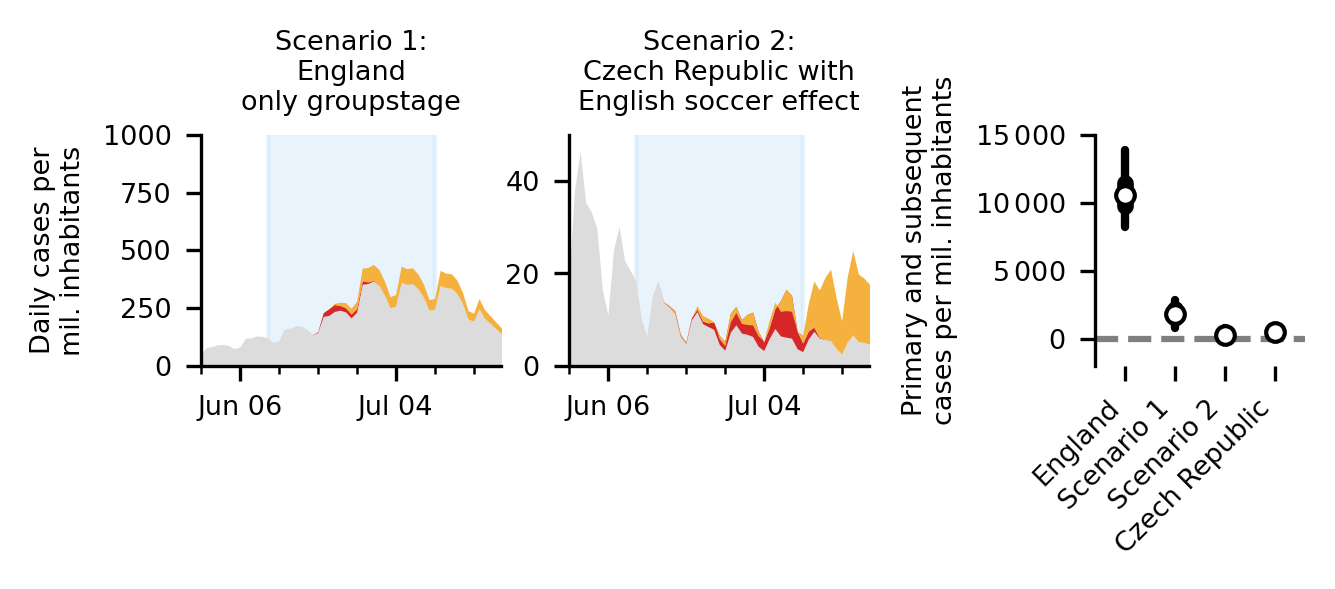

In [274]:
## Plotting
from covid19_soccer.plot.timeseries import _uefa_range, incidence, stacked_filled, fraction_male_female, _timeseries, format_date_axis


fig, axes = plt.subplots(1,4,figsize=(4.75,1.0), gridspec_kw={"wspace":0.3, "width_ratios":[1,1,0.3,0.7]})
colors_base = ["gainsboro","tab:red","#f5b13d"]


x, y = get_xy(trace_no_GS,trace_no_GS_no_soccer,trace_no_GS_primary)
for j in range(len(y)):
    y[j] = y[j]/np.sum(dls[0].population)*1e6
    
_uefa_range(axes[0])
stacked_filled(
    x,
    [yi for yi in y],
    ax=axes[0],
    colors=colors_base,
    label="b",
)
axes[0].set_ylim(0,1000)
axes[0].set_ylabel("Daily cases per\nmil. inhabitants")
axes[0].set_xlim(*xlim_ts)
axes[0].set_title("Scenario 1:\nEngland\nonly groupstage")

x, y = get_xy(
    trace_czechia_with_england_participation,
    trace_czechia_with_england_participation_no_soccer,
    trace_czechia_with_england_participation_primary
)

for j in range(len(y)):
    y[j] = y[j]/np.sum(dls[1].population)*1e6

_uefa_range(axes[1])

stacked_filled(
    x,
    [yi for yi in y],
    ax=axes[1],
    colors=colors_base,
    label="b",
)
"""
axes[1].set_ylim(0,4000)
#axes[1].set_ylabel("Daily cases per\nmil. inhabitants")
axes[1].set_xlim(*xlim_ts)

nc = get_from_trace("new_cases",trace_czechia_with_england_participation)
axes[1].plot(x,nc.sum(axis=-1).mean(axis=0)/np.sum(dls[1].population[0])*1e6)

nc = get_from_trace("new_cases",trace_czechia_with_england_participation_no_soccer,from_type="predictions")
axes[1].plot(x,nc.sum(axis=-1).mean(axis=0)/np.sum(dls[1].population[0])*1e6)

nc = get_from_trace("new_cases",trace_czechia_with_england_participation_primary,from_type="predictions")
axes[1].plot(x,nc.sum(axis=-1).mean(axis=0)/np.sum(dls[1].population[0])*1e6)
"""

axes[1].set_ylim(0,50)
#axes[1].set_ylabel("Daily cases per\nmil. inhabitants")
axes[1].set_xlim(*xlim_ts)
axes[1].set_title("Scenario 2:\nCzech Republic with\nEnglish soccer effect")

axes[2].set_axis_off()

ax = axes[3]

traces_for_panel = [(traces[0], trace_england_no_soccer,trace_england_primary),
                    (trace_no_GS,trace_no_GS_no_soccer,trace_no_GS_primary),
                    (trace_czechia_with_england_participation,trace_czechia_with_england_participation_no_soccer,trace_czechia_with_england_participation_primary), 
                    (traces[1], trace_czechia_no_soccer,trace_czechia_primary)] 
countries_index = [0,0,1,1]

for i in range(4):
    cases_primary_and_subs = get_primary_and_subsequent(*traces_for_panel[i])
    inci_primary_and_subs = cases_primary_and_subs/np.sum(dls[countries_index[i]].population)*1e6
    print(inci_primary_and_subs)
    plot_var(ax, inci_primary_and_subs, i, color="black", vertical=False)
    
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(False)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["England", "Scenario 1","Scenario 2","Czech Republic"],rotation=45, ha='right')
ax.tick_params(axis="x",left=False)
#ax.tick_params(axis="y",direction="in", pad=-22)

# ax2.set_yscale('symlog', linthresh=1e2,base=100)
# ax2.set_yticks([-1e4,-1e2,0,1e2,1e4,1e6])
# ax2.yaxis.set_minor_locator(MinorSymLogLocator(1e2))
# ax2.set_ylim(-1e5,1e5)

def formatter(x,pos):
    if x > 1000:
        return '{:,.0f}'.format(x).replace(',', '$\,$')
    else:
        return '{:,.0f}'.format(x)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlim(-0.6, 3.6)
ax.set_ylim(-2000,15000)
ax.set_ylabel("Primary and subsequent\ncases per mil. inhabitants");
ax.axhline(0, color="tab:gray", ls="--", zorder=-10)
#plt.tight_layout()
fig.savefig("./figures/counterfactuals.pdf", **save_kwargs)

plt.show()


WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


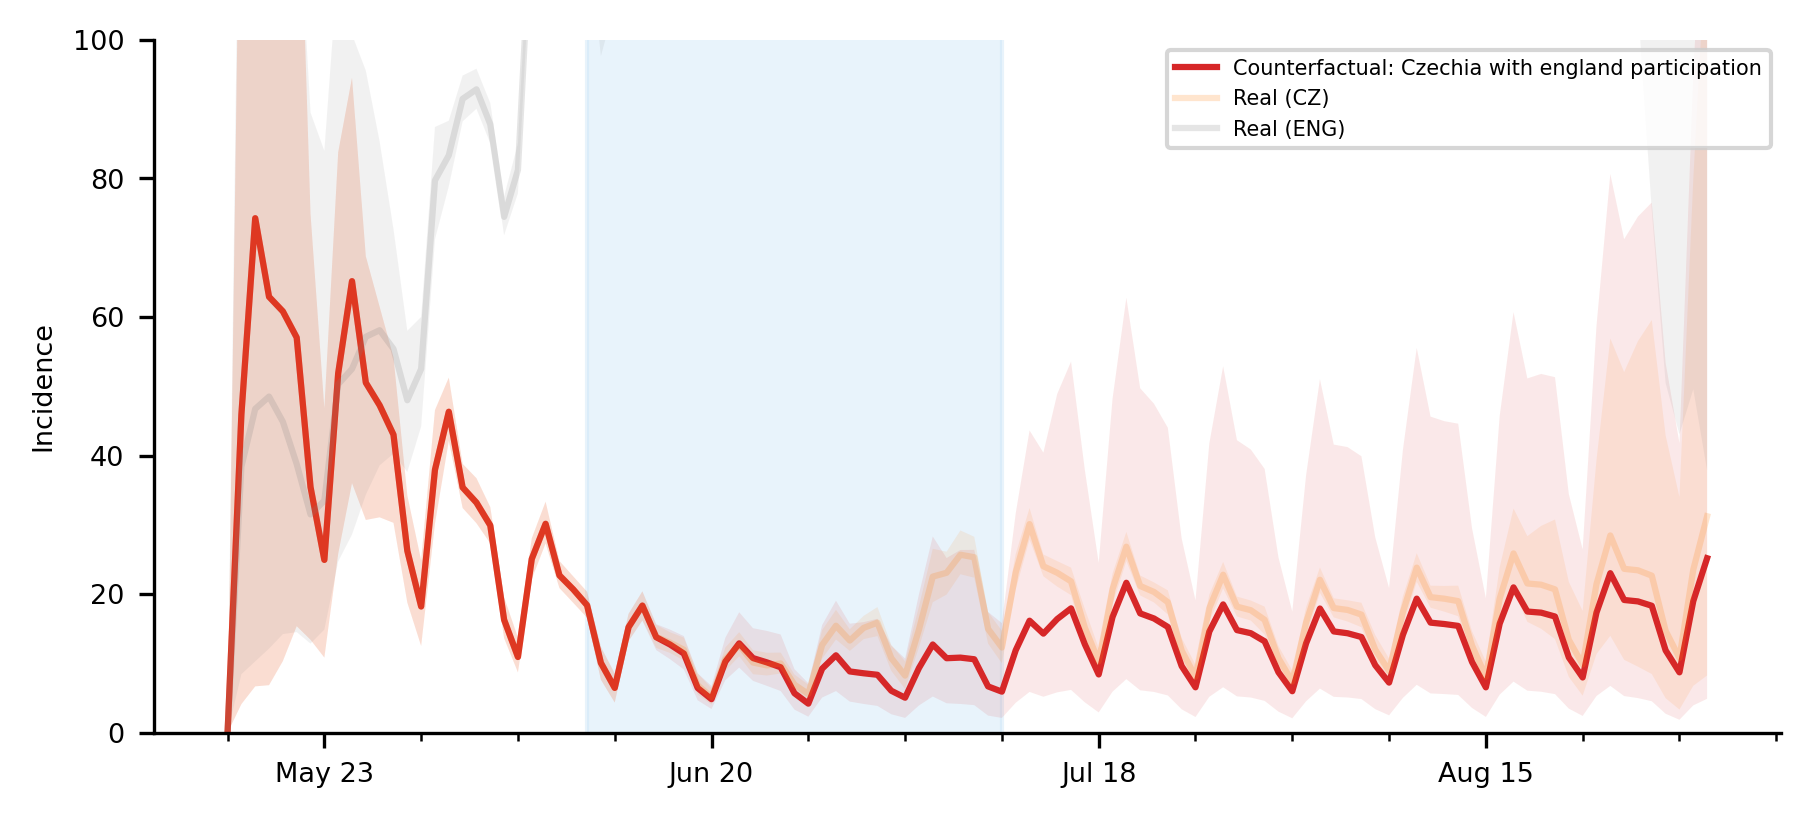

In [276]:
## Plotting
from covid19_soccer.plot.timeseries import _uefa_range, incidence, stacked_filled, fraction_male_female, _timeseries, format_date_axis

new_cases_cz_with_eng_part = get_from_trace("new_cases",prediction_czechia_with_england_participation,from_type="predictions")
new_cases_normal_eng = get_from_trace("new_cases",traces[0])
new_cases_normal_cz = get_from_trace("new_cases",traces[1])
x = pd.date_range(models[0].sim_begin,models[0].sim_end)

fig, ax = plt.subplots(1,1,figsize=(7,3))
_timeseries(
    x=x,
    y=(new_cases_cz_with_eng_part[:, :, 0] + new_cases_cz_with_eng_part[:, :, 1])
    / (dls[1].population[0, 0] + dls[1].population[1, 0])
    * 1e6,  # incidence
    what="model",
    ax=ax,
    color="tab:red",
    label="Counterfactual: Czechia with england participation"
)

_timeseries(
    x=x,
    y=(new_cases_normal_cz[:, :, 0] + new_cases_normal_cz[:, :, 1])
    / (dls[1].population[0, 0] + dls[1].population[1, 0])
    * 1e6,  # incidence
    what="model",
    color="tab:orange",
    ax=ax,
    label="Real (CZ)",
    alpha=0.2
)
_timeseries(
    x=x,
    y=(new_cases_normal_eng[:, :, 0] + new_cases_normal_eng[:, :, 1])
    / (dls[0].population[0, 0] + dls[0].population[1, 0])
    * 1e6,  # incidence
    what="model",
    color="tab:gray",
    ax=ax,
    label="Real (ENG)",
    alpha=0.2
)


# Plot shaded uefa
_uefa_range(ax)
ax.set_ylabel("Incidence")
format_date_axis(ax)
ax.legend()
#ax.set_xlim(*xlim_ts)
ax.set_ylim(0,100)
plt.show()